In [1]:
%autosave 60

Autosaving every 60 seconds


# Оглавление
* [0. Установка зависимостей и импорт библиотек](#chapter_0)
* [1. Просмотр данных](#chapter_1)
* [2. Построение итоговой модели](#chapter_2)
    * [Intro (*public MSE=9884*, *privat MSE=9449*)](#chapter_2_1)
        * [1. Обработка данных](#chapter_2_1_1)
        * [2. Модель](#chapter_2_1_2)
        * [3. Использование особенностей при обучении модели](#chapter_2_1_3)
        * [3. Валидация алгоритма](#chapter_2_1_4)
    * [Outro](#chapter_2_2)

## 0. Установка зависимостей и импорт библиотек <a class="anchor" id="chapter_0"></a>

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"dotyushka666","key":"unk"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c teta-ml-2-2025
!unzip /kaggle/working/teta-ml-2-2025.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 3.6 MB/s eta 0:00:00a 0:00:01
Archive:  /kaggle/working/teta-ml-2-2025.zip
  inflating: sample_submition.csv    
  inflating: test.csv                
  inflating: train.csv               


In [4]:
!pip install reverse_geocoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.1 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268068 sha256=a837329137da497e47abd42429ec5163842f0f029b06af40a6378157af0e7966
  Stored in directory: /root/.cache/pip/wheels/bd/e5/88/eb139b6d6a26b8022d370ab991f7a836802fed9871975ec6d9
Successfully built reverse_geocoder


In [2]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import reverse_geocoder as rg
import seaborn as sns
from catboost import CatBoostRegressor, cv, Pool
from geopy.distance import great_circle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [3]:
RANDOM_STATE = 64

## 1. Просмотр данных <a id="chapter_1"></a>

In [4]:
df_house = pd.read_csv("train.csv")
df_house.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host,target
0,Belle Harbor 4 BR 2 bath- 1 bl from Beach,40327248,Sarina,Queens,Neponsit,40.57215,-73.85822,Entire home/apt,350,2,5,2019-07-07,2.88,1,334
1,"Come see Brooklyn, New York",13617520,Howard T.,Brooklyn,Clinton Hill,40.69172,-73.96934,Shared room,40,5,8,2015-02-25,0.13,1,0
2,Large 2Br on W71st & Columbus Feb 19-28,26754726,Julie,Manhattan,Upper West Side,40.77673,-73.98011,Entire home/apt,200,5,0,NaN,NaN,1,0
3,Perfect bedroom. Near Subways Columbia CityCol...,16721721,Federico,Manhattan,Harlem,40.81530,-73.95080,Private room,65,2,18,2018-11-04,0.64,1,0
4,Cozy Sun Filled Fresh Guest Room in Artsy Bush...,22246463,Lisa,Brooklyn,Bushwick,40.70230,-73.92935,Private room,99,2,26,2019-06-23,0.76,1,155


In [5]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36671 entries, 0 to 36670
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              36662 non-null  object 
 1   _id               36671 non-null  int64  
 2   host_name         36653 non-null  object 
 3   location_cluster  36671 non-null  object 
 4   location          36671 non-null  object 
 5   lat               36671 non-null  float64
 6   lon               36671 non-null  float64
 7   type_house        36671 non-null  object 
 8   sum               36671 non-null  int64  
 9   min_days          36671 non-null  int64  
 10  amt_reviews       36671 non-null  int64  
 11  last_dt           29169 non-null  object 
 12  avg_reviews       29169 non-null  float64
 13  total_host        36671 non-null  int64  
 14  target            36671 non-null  int64  
dtypes: float64(3), int64(6), object(6)
memory usage: 4.2+ MB


In [6]:
print("Данные, которые содержат дубликаты:")
df_house[df_house.duplicated()]

Данные, которые содержат дубликаты:


,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host,target


Пропущенные значения в каждом столбце:
name                   9
_id                    0
host_name             18
location_cluster       0
location               0
lat                    0
lon                    0
type_house             0
sum                    0
min_days               0
amt_reviews            0
last_dt             7502
avg_reviews         7502
total_host             0
target                 0
dtype: int64


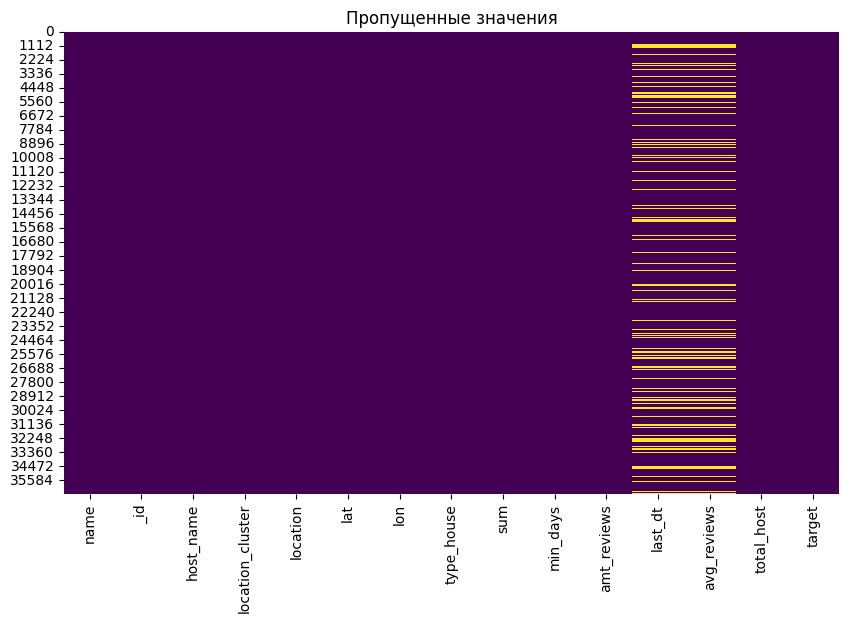

In [7]:
missing_values = df_house.isnull().sum()

print("Пропущенные значения в каждом столбце:")
print(missing_values)

plt.figure(figsize=(10, 6))
sns.heatmap(df_house.isnull(), cbar=False, cmap="viridis")
plt.title("Пропущенные значения")
plt.show()

In [8]:
df_house.describe()

,_id,lat,lon,sum,min_days,amt_reviews,avg_reviews,total_host,target
count,3.667100e+04,36671.000000,36671.000000,36671.000000,36671.000000,36671.000000,29169.000000,36671.000000,36671.000000
mean,6.720433e+07,40.729080,-73.951958,152.142292,7.053176,23.433667,1.365601,7.047694,112.766628
std,7.828147e+07,0.054671,0.046201,239.107973,21.539569,44.703590,1.643966,32.595427,131.583284
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,7.780024e+06,40.690090,-73.982970,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,3.053256e+07,40.723150,-73.955560,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,1.074344e+08,40.763260,-73.935865,175.000000,5.000000,24.000000,2.010000,2.000000,227.000000
max,2.743213e+08,40.912340,-73.712990,10000.000000,1250.000000,629.000000,20.940000,327.000000,365.000000


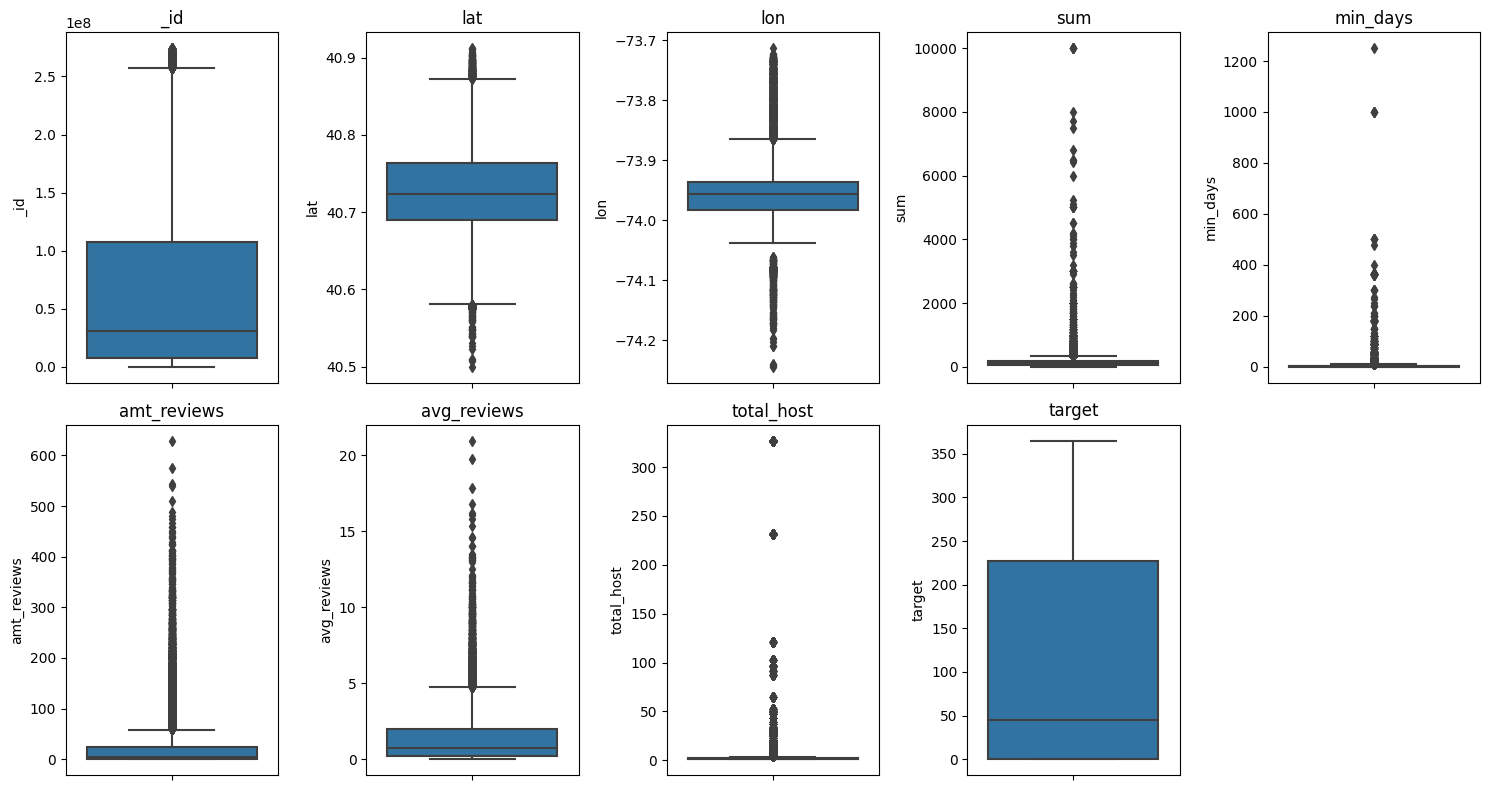

In [9]:
numerical_columns = df_house.select_dtypes(include=["float64", "int64"]).columns

plt.figure(figsize=(15, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 5, i)
    sns.boxplot(y=df_house[column])
    plt.title(column)
plt.tight_layout()
plt.show()

In [10]:
categorical_columns = df_house.select_dtypes(include=["object"]).columns

print("Уникальные значения в категориальных признаках:")
for column in categorical_columns:
    print(f"{column}: {df_house[column].nunique()} уникальных значений")
    print(df_house[column].value_counts())
    print("\n")

Уникальные значения в категориальных признаках:
name: 36076 уникальных значений
name
New york Multi-unit building                         14
Hillside Hotel                                       14
Private Room                                         11
Home away from home                                  10
Brooklyn Apartment                                   10
                                                     ..
A Room in Park Slope                                  1
Private bed/ bath in classic Upper West Side apt.     1
Nice room to rent at Midtown Manhattan                1
Three-story brownstone with garden                    1
Lovely & Cozy Apartment in Queens!                    1
Name: count, Length: 36076, dtype: int64


host_name: 9629 уникальных значений
host_name
Michael         308
David           306
Sonder (NYC)    238
John            223
Alex            205
               ... 
Taran Pal         1
Erion             1
Ginta             1
Shivangi          1
Tuva      

## 2. Построение итоговой модели <a id="chapter_2"></a>

### Intro (*public MSE=9884*, *privat MSE=9449*) <a id="chapter_2_1"></a>
#### 1. Обработка данных <a id="chapter_2_1_1"></a>
Обработка данных заключалась в следующем:
- Извлечение дополнительных фичей для модели:
    - геокодирование координат (широта/долгота) с добавлением административных регионов;
    - временные фичи из даты последнего отзыва/последнего бронирования.
- Обработка текста (**name**): приведение к нижнему регистру, очистка регуляркой от всех символов, кроме буквенных.
- Пропуски заполнялись после извлечение всех фичей внутри catboost по дефолту:
    - *Min* для числовых фичей;
    - *Ничего* для текстовых.

Также было сделано сжатие данных для числовых типов, чтобы модель быстрее обучалась без потери в качестве.

#### 2. Модель <a id="chapter_2_1_2"></a>
В качетсве модели был взят градиентный бустинг в исполнении *catboost*, т.к. есть следующие преимущества:
- Автоматическая обработка категориальных фичей и Nan'ов.
- Встроенная поддержка текстовых фичей.

#### 3. Использование особенностей при обучении модели <a id="chapter_2_1_3"></a>
- Использование *StratifiedShuffleSplit* для кросс-валидации.
- Функция потерь RMSE.
- Мониторинг качества на отложенной выборке. Предикты делались с округлением до целого числа и обрезкой от 0 до 365 (наблюдение из данных).
- Мониторинг важности фичей через *get_feature_importance*.

#### 4. Валидация алгоритма <a id="chapter_2_1_4"></a>
- *Кросс-валидация* (3 фолда) для подбора гиперпараметров.
- *Ранняя остановка*, если метрика не улучшается.
- *Финальная оценка* на полностью изолированном тестовом наборе.

### Outro <a id="chapter_2_2"></a>
1. Учет важности фичей через *permutation importance*. 
    Дописать алгоритм для извлечения значимых признаков.
2. Переделать функцию потерь. Группировка и добавление временных фичей (средние, rolling, shift).
- Переделать сплит по времени. Продумать обучение алгоритма и валидацию. 
- Переделать функцию потерь для учитывания того, что у нас целочисленные значения $\geq 0$. (Были попытки, но качество было значительно хуже RMSE с пост обработкой).
> Есть проблема с работой для данного предложения, т.к. в данных трейна и теста, предложенного организаторами, временной промежуток один и тот же практически. Есть семплы, у которых время происходит позже в трейне, чем в тесте.
> При этом фичи пытались добавляться (с дата-ликом и без), но прироста особого не дают. Надо разбираться почему.
3. Применения блэндинга из базовых алгоритмов.
    Для этого надо дообучить еще несколько алгоритмов и объединить их.

In [11]:
class PreprocessDataCatBoost:
    def __init__(
        self,
        cat_features: list[str] = None,
        text_features: list[str] = None,
        optimize_type: bool = False,
    ):
        self.cat_features = cat_features
        self.text_features = text_features
        self.optimize_type = optimize_type

    @staticmethod
    def get_info_coord(coord: tuple[tuple]):
        try:
            location = rg.search(coord)
            return location
        except:
            return {}

    @staticmethod
    def clean_text(text):
        cleaned = re.sub(r"[^a-zA-Z\s]", "", str(text))
        cleaned = re.sub(r"\s+", " ", cleaned).strip()
        return cleaned

    @staticmethod
    def calculate_distance(row_client: tuple[float], merchant_coords: tuple[float]):
        return great_circle(row_client, merchant_coords).km

    @staticmethod
    def _can_convert_to_smaller_int(series, target_type="int32"):
        try:
            converted = series.astype(target_type)
            return (series == converted).all()
        except:
            return False

    @staticmethod
    def _can_convert_to_float32(series):
        try:
            converted = series.astype("float32").astype("float64")
            return np.allclose(series, converted, atol=1e-4)
        except:
            return False

    def optimize_dtypes(self, df):
        for col in df.columns:
            col_type = df[col].dtype

            if col_type == "float64":
                if self._can_convert_to_float32(df[col]):
                    df[col] = df[col].astype("float32")

            elif col_type == "int64":
                if self._can_convert_to_smaller_int(df[col], "int32"):
                    df[col] = df[col].astype("int32")
                elif self._can_convert_to_smaller_int(df[col], "int16"):
                    df[col] = df[col].astype("int16")

        return df

    def general_preprocess(self, data: pd.DataFrame):
        df_train = data.copy(deep=True)
        df_train["last_dt"] = pd.to_datetime(df_train["last_dt"])

        df_train["name"] = df_train["name"].str.lower()
        df_train["name"] = df_train["name"].fillna("")
        df_train["name"] = df_train["name"].apply(self.clean_text)

        df_train["days_since_last_review"] = (
            (df_train["last_dt"].max() - df_train["last_dt"])
            .dt.days
        )

        df_train["year"] = df_train["last_dt"].dt.year
        df_train["month"] = df_train["last_dt"].dt.month
        df_train["day_of_month"] = df_train["last_dt"].dt.day
        df_train["day_of_week"] = (
            df_train["last_dt"].dt.dayofweek
        )

        df_train["avg_reviews"] = df_train["avg_reviews"]

        uniq_coord = tuple(df_train[["lat", "lon"]].itertuples(index=False, name=None))
        dict_coords = self.get_info_coord(uniq_coord)
        coords = pd.DataFrame(dict_coords)
        coords = coords.rename(
            columns={
                "lat": "lat_coords",
                "lon": "lon_coords",
                "name": "name_coords",
                "admin1": "admin1_coords",
                "admin2": "admin2_coords",
                "cc": "cc_coords",
            }
        )
        coords = coords.drop(columns=["cc_coords"])
        df_train = pd.concat([df_train, coords], axis=1)

        df_train["distance_km_centre"] = df_train.apply(
            lambda x: self.calculate_distance(
                (x["lat"], x["lon"]), (x["lat_coords"], x["lon_coords"])
            ),
            axis=1,
        )

        df_train["is_out_of_name"] = (
            df_train["name_coords"] != df_train["location_cluster"]
        ).astype(int)

        df_train["host_name"] = df_train["host_name"].astype(str)

        df_train.drop(
            columns=["last_dt", "_id", "lat_coords", "lon_coords", "lat", "lon"],
            inplace=True,
        )

        if self.optimize_type:
            df_train = self.optimize_dtypes(df_train)

        return df_train

    def preprocess(self, data: pd.DataFrame):
        data = data.reset_index(drop=True)

        preprocess_data = self.general_preprocess(data)

        return preprocess_data

    def transform(self, data: pd.DataFrame):
        data = data.reset_index(drop=True)

        preprocess_data = self.general_preprocess(data)

        return preprocess_data


class ModelPipeline:
    def __init__(self, model):
        self.model = model

    def fit(
        self,
        X: pd.DataFrame,
        y: pd.DataFrame,
        eval_set: list[tuple[pd.DataFrame]] = None,
    ):
        if eval_set:
            self.model.fit(X, y, eval_set=eval_set)
        else:
            self.model.fit(X, y)

    def fit_k_fold(self, X: pd.DataFrame, y: pd.DataFrame, k_fold: int = 3):
        stratified_shuffle_split = StratifiedShuffleSplit(
            n_splits=k_fold, test_size=0.2, random_state=RANDOM_STATE
        )

        cv_dataset = Pool(
            data=X,
            label=y,
            cat_features=self.model.get_param("cat_features"),
            text_features=self.model.get_param("text_features"),
        )

        params: dict = self.model.get_params().copy()
        params.pop("cat_features")
        params.pop("text_features")

        cv_results = cv(
            cv_dataset,
            params,
            folds=stratified_shuffle_split,
        )

        return cv_results

    def _calculate_metrics(y, y_pred):
        return mean_squared_error(y, y_pred)

    def predict(self, X):
        y_pred = self.model.predict(X)

        return np.round(y_pred).clip(0, 365)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return self._calculate_metrics(y, y_pred)


In [12]:
preprocessing_catboost = PreprocessDataCatBoost(
    text_features=["name"], optimize_type=True
)

In [13]:
X = df_house.drop("target", axis=1)
y = df_house["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=df_house["type_house"]
)

In [14]:
X_train_transform = preprocessing_catboost.preprocess(X_train)
X_test_transform = preprocessing_catboost.transform(X_test)

assert X_train_transform.shape[1] == X_test_transform.shape[1]

print(X_train_transform.info())
X_train_transform.head()

Loading formatted geocoded file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29336 entries, 0 to 29335
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    29336 non-null  object 
 1   host_name               29336 non-null  object 
 2   location_cluster        29336 non-null  object 
 3   location                29336 non-null  object 
 4   type_house              29336 non-null  object 
 5   sum                     29336 non-null  int32  
 6   min_days                29336 non-null  int32  
 7   amt_reviews             29336 non-null  int32  
 8   avg_reviews             23367 non-null  float64
 9   total_host              29336 non-null  int32  
 10  days_since_last_review  23367 non-null  float64
 11  year                    23367 non-null  float64
 12  month                   23367 non-null  float64
 13  day_of_month            23367 non-null  float64
 14  day

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,name,host_name,location_cluster,location,type_house,sum,min_days,amt_reviews,avg_reviews,total_host,days_since_last_review,year,month,day_of_month,day_of_week,name_coords,admin1_coords,admin2_coords,distance_km_centre,is_out_of_name
0,bedstuy brooklyn private bedroom,Kamerin,Brooklyn,Bedford-Stuyvesant,Private room,35,4,0,NaN,1,NaN,NaN,NaN,NaN,NaN,East New York,New York,Kings County,3.643219,1
1,private bedroom in soho,Charlotte,Manhattan,Tribeca,Private room,110,1,0,NaN,1,NaN,NaN,NaN,NaN,NaN,New York City,New York,,0.608267,1
2,sonder hanover square simple br rooftop,Sonder,Manhattan,Financial District,Entire home/apt,182,29,2,0.24,96,98.0,2019.0,4.0,1.0,0.0,New York City,New York,,1.064714,1
3,peaceful sunny greenpoint room,Paul,Brooklyn,Greenpoint,Private room,66,1,1,0.02,1,1213.0,2016.0,3.0,12.0,5.0,Long Island City,New York,Queens County,1.675125,1
4,waterfront condo with swimming pool,Alessandro,Brooklyn,Williamsburg,Private room,70,2,14,1.52,2,14.0,2019.0,6.0,24.0,0.0,Long Island City,New York,Queens County,3.092142,1


In [15]:
text_features = preprocessing_catboost.text_features

preprocessing_catboost.cat_features = cat_features = [
    column
    for column in X_train_transform.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()
    if column not in text_features
]

In [16]:
model_regressor = ModelPipeline(
    CatBoostRegressor(
        iterations=1024,
        learning_rate=0.15,
        depth=9,
        loss_function="RMSE",
        eval_metric="RMSE",
        early_stopping_rounds=50,
        verbose=30,
        cat_features=cat_features,
        text_features=text_features,
        subsample=0.7,
        random_state=RANDOM_STATE,
        task_type="CPU",
    )
)

In [17]:
model_regressor.fit_k_fold(X_train_transform, y_train)

Training on fold [0/3]
0:	learn: 159.7221599	test: 159.7052945	best: 159.7052945 (0)	total: 1.11s	remaining: 18m 55s
30:	learn: 103.4962944	test: 105.9432794	best: 105.9432794 (30)	total: 37.5s	remaining: 20m
60:	learn: 100.9337857	test: 104.4717278	best: 104.4717278 (60)	total: 1m 13s	remaining: 19m 16s
90:	learn: 98.2506964	test: 103.3737571	best: 103.3737571 (90)	total: 1m 49s	remaining: 18m 39s
120:	learn: 95.9375377	test: 102.2759245	best: 102.2759245 (120)	total: 2m 25s	remaining: 18m 2s
150:	learn: 94.1277320	test: 101.8468336	best: 101.8468336 (150)	total: 3m	remaining: 17m 24s
180:	learn: 92.8961905	test: 101.6833096	best: 101.6833096 (180)	total: 3m 36s	remaining: 16m 46s
210:	learn: 91.8590059	test: 101.5429434	best: 101.5401518 (209)	total: 4m 11s	remaining: 16m 10s
240:	learn: 90.8380709	test: 101.5524023	best: 101.5143173 (234)	total: 4m 47s	remaining: 15m 34s
270:	learn: 89.7447373	test: 101.4795292	best: 101.4745656 (269)	total: 5m 23s	remaining: 14m 57s
300:	learn: 88.

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,159.628205,0.129467,159.678650,0.197408
1,1,148.672819,0.356488,148.796166,0.402310
2,2,139.856403,0.275037,139.967539,0.237403
3,3,132.827237,0.156704,132.886448,0.009051
4,4,127.347570,0.185947,127.371798,0.476346
...,...,...,...,...,...
428,428,100.279230,0.826335,86.112983,0.916525
429,429,100.277456,0.823312,86.099818,0.939271
430,430,100.277873,0.824022,86.097127,0.943921
431,431,100.277330,0.823098,86.086228,0.962754


In [18]:
eval_set = [(X_test_transform, y_test)]

model_regressor.fit(X_train_transform, y_train, eval_set=eval_set)

0:	learn: 126.5976066	test: 125.2202704	best: 125.2202704 (0)	total: 1.15s	remaining: 19m 40s
30:	learn: 102.7844171	test: 102.2474594	best: 102.2474594 (30)	total: 38.8s	remaining: 20m 42s
60:	learn: 100.2947989	test: 100.5550021	best: 100.5550021 (60)	total: 1m 16s	remaining: 20m 14s
90:	learn: 98.0397546	test: 99.5181907	best: 99.5181907 (90)	total: 1m 55s	remaining: 19m 40s
120:	learn: 96.2184006	test: 98.9624990	best: 98.9607170 (119)	total: 2m 33s	remaining: 19m 3s
150:	learn: 94.7232304	test: 98.6393122	best: 98.6393122 (150)	total: 3m 11s	remaining: 18m 25s
180:	learn: 93.8783399	test: 98.6063179	best: 98.5808290 (173)	total: 3m 49s	remaining: 17m 48s
210:	learn: 92.7286586	test: 98.3727074	best: 98.3727074 (210)	total: 4m 27s	remaining: 17m 11s
240:	learn: 91.8706145	test: 98.3865027	best: 98.3516222 (220)	total: 5m 5s	remaining: 16m 33s
270:	learn: 90.9166626	test: 98.2907061	best: 98.2844020 (267)	total: 5m 43s	remaining: 15m 54s
300:	learn: 90.1373045	test: 98.1520975	best:

In [19]:
y_pred = model_regressor.predict(X_test_transform)

print(f"MSE: {mean_squared_error(y_test, y_pred)}")

MSE: 9591.969597818677


In [20]:
importance_features_ctb = pd.DataFrame(
    data={
        "features": X_train_transform.columns.to_list(),
        "score": model_regressor.model.get_feature_importance(),
    }
)

importance_features_ctb.sort_values(by="score", ascending=False)

,features,score
9,total_host,15.578231
0,name,12.366373
6,min_days,9.708530
5,sum,8.598208
7,amt_reviews,7.861663
11,year,6.812405
3,location,6.040384
8,avg_reviews,6.001982
1,host_name,5.080865
10,days_since_last_review,5.064221


In [21]:
model_regressor_full_data = ModelPipeline(
    CatBoostRegressor(**model_regressor.model.get_params())
)
model_regressor_full_data.model.set_params(iterations=336)

full_data_train = preprocessing_catboost.preprocess(X)

model_regressor_full_data.fit(full_data_train, y)

0:	learn: 126.0643338	total: 1.19s	remaining: 6m 37s
30:	learn: 101.6612284	total: 40.3s	remaining: 6m 36s
60:	learn: 99.7477687	total: 1m 18s	remaining: 5m 55s
90:	learn: 97.7229454	total: 1m 57s	remaining: 5m 15s
120:	learn: 95.9920236	total: 2m 36s	remaining: 4m 37s
150:	learn: 94.5757909	total: 3m 14s	remaining: 3m 58s
180:	learn: 93.4156231	total: 3m 53s	remaining: 3m 19s
210:	learn: 92.4607465	total: 4m 32s	remaining: 2m 41s
240:	learn: 91.6235711	total: 5m 10s	remaining: 2m 2s
270:	learn: 90.8332078	total: 5m 48s	remaining: 1m 23s
300:	learn: 90.0888148	total: 6m 27s	remaining: 45.1s
330:	learn: 89.3796358	total: 7m 5s	remaining: 6.43s
335:	learn: 89.2458443	total: 7m 12s	remaining: 0us


In [ ]:
df_house_test = pd.read_csv("test.csv")

df_house_train = df_house.copy(deep=True).reset_index()
df_house_test = df_house_test.reset_index()

df_house_train["test_columns"] = 0
df_house_test["test_columns"] = 1

df_full = pd.concat(
    [df_house_train.drop(columns=["target"]), df_house_test], axis=0, ignore_index=True
)

df_test = preprocessing_catboost.preprocess(df_full)

df_test = (
    df_test[df_test["test_columns"] == 1]
    .sort_values(by="index")
    .drop(columns=["test_columns", "index"])
)

assert df_test.shape[1] == X_train_transform.shape[1]

y_test = model_regressor_full_data.predict(df_test)

assert y_test.shape[0] == 12224

In [23]:
df_predict_test = pd.DataFrame(y_test, columns=["prediction"]).reset_index()

In [24]:
df_predict_test.to_csv("catboost_v3_add_clean_text.csv", index=None)